# **Final Exam for Deep Network Development course. First part (mandatory)**

This notebook contains the task to be solved in order to pass the exam.
This is the first part of the exam, which is compolsury in order to get a grade. It contains a task similar to what you have worked on during the semester, which consists on implementing a network architecture and a function.

Please note that, to **PASS** the Deep Network Development course you must **SUBMIT A SUCCESSFUL SOLUTION FOR THE FIRST PART**. If you **FAIL** the first part, you have the right to do the exam **ONE MORE TIME**. If you **FAIL AGAIN**, then unfortunately, you have failed the course. If you **PASS** the first part, then you get the weighted average of your quizzes and assignments as your final grade.

## Your information
Please fill the next cell with your information

**Full Name**:

**Neptun code:**

**Date:** 09/01/2024 9AM-10AM

## Task Description

#### Your task is to implement a custom architecture inspired by a image-to-image Diffusion like model, and the forward function. The model receives an intial image and a text as input (describes how the final image should look like) and generates an image according to the two.

#### Afterwards, make sure to run cell code number 1.2. to check if your implementation is correct.

#### This task should be **SOLVED IN 1 HOUR** and submitted to Canvas (download the .ipynb file). Please note that after 1 hour, the Canvas exam assignment will be closed and you cannot submit your solution.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#### **NO GPU IS NEEDED for this task**. No training nor any computationally expensive operation will be performed. This notebook runs on any computer using a cpu.

In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device

## 1. Architecture

#### Please keep in mind that this architecture is purely imagined and should not correspond to any existing model / architecture. You will not find it on the internet.

Please right click the image and "Open image in a new tab" to view it better with zoom. Or download it from here: https://drive.google.com/file/d/11gey3SssCJe6CIUiFON9e-eoLdkegDna/view?usp=drive_link

<br>
<br>

![](https://drive.google.com/uc?export=view&id=11gey3SssCJe6CIUiFON9e-eoLdkegDna)

#### Input image

In [1]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

response = requests.get("https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/1200px-Cat_November_2010-1a.jpg")
image = Image.open(BytesIO(response.content)).convert('RGB')
image = image.resize((256, 256))
image = np.rollaxis(np.array(image), 2, 0)

In [2]:
image.shape

(3, 256, 256)

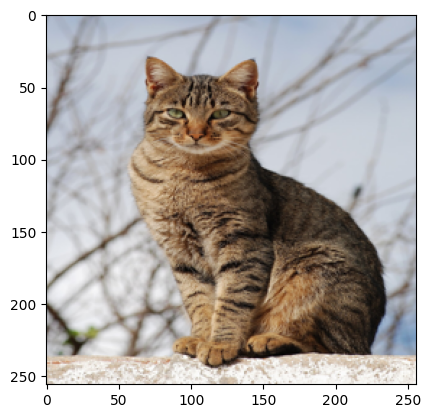

In [3]:
plt.imshow(np.moveaxis(image, 0,-1))

In [6]:
#Simple pre-processing
input_image = torch.tensor(image,dtype=torch.float32)
input_image = torch.unsqueeze(input_image, dim=0)
input_image.size()

torch.Size([1, 3, 256, 256])

#### Input text

In [7]:
text = "A cat wearing sunglasses and suit"

# Simple preprocessing the text
word_to_ix = {"A": 0, "cat": 1, "wearing": 2, "sunglasses": 3, "and": 4, "suit": 5}
lookup_tensor = torch.tensor(list(word_to_ix.values()), dtype=torch.long) # a tensor representing words by integers

vocab_size = len(lookup_tensor)

In [8]:
vocab_size

6

#### 1.1. Implement the architecture

In [50]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, out_channels):
        super(TextEncoder, self).__init__()
        #text encoder
        self.embed=nn.Embedding(6,1024)


    def forward(self, input_text):
        # EMBED the input text
        x=self.embed(input_text)
        print('embedding')
        print(x.shape)
        x_reshape=x.view(1, 6, 32, 32)
        print('reshape')
        print(x_reshape.shape)

        x1=nn.ConvTranspose2d(6,32,kernel_size=4, stride=4, padding=0)(x_reshape)
        print('convtranspose')
        print(x1.shape)




        return x1

class ImageEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImageEncoder, self).__init__()
        self.upper=nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            )

    def forward(self, input_image):
        x=self.upper(input_image)
        print('upper')
        print(x.shape)
        # SEND the input image and then the features to the given layers

        return x

class ImageDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImageDecoder, self).__init__()
        self.image2=nn.Sequential(nn.BatchNorm2d(64),
                                nn.ConvTranspose2d(64, 3,kernel_size=2,stride=2),
                                nn.ReLU())

    def forward(self, image_features):
        # SEND the image features to the given layers
        x=self.image2(image_features)
        print('image2')
        print(x.shape)
        return x

class MyUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MyUNet, self).__init__()
        self.unet1=nn.Sequential(nn.Conv2d(96,128,kernel_size=3,padding='same'),
                                nn.ReLU())
        self.unet2=nn.Sequential(nn.Conv2d(96,128,kernel_size=3,padding='same'),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2,stride=2),
                                nn.Conv2d(128,256,kernel_size=3,padding='same'),
                                nn.ReLU())

        self.unet3=nn.Sequential(nn.Conv2d(96,128,kernel_size=3,padding='same'),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2,stride=2),
                                nn.Conv2d(128,256,kernel_size=3,padding='same'),
                                nn.ReLU(),
                                nn.Conv2d(256,64,kernel_size=2,padding='same'),
                                nn.ReLU())

    def forward(self, combined_features):
        x=combined_features
        x1=self.unet1(x)

        print('unet1')
        print(x.shape)
        x2=self.unet2(x)
        print('unet2')
        print(x2.shape)
        x3=self.unet3(x)
        print('unet3')
        print(x3.shape)
        x4=torch.cat((x2,x3),dim=1)
        print('cat')
        print(x4.shape)
        x5=nn.ConvTranspose2d(320,128,kernel_size=4,stride=2,padding=1)(x4)
        print('convtranspose')
        print(x5.shape)
        x6=torch.cat((x1,x5),dim=1)
        print('cat')
        print(x6.shape)
        x7=nn.ConvTranspose2d(256,64,kernel_size=3,padding=1)(x6)
        print('convtranspose')
        x7=nn.ReLU()(x7)
        print('relu')
        print(x7.shape)


        return x7

class ImageToImageGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, image_channels, text_encoder_out_channels, image_encoder_out_channels, unet_out_channels):
        super(ImageToImageGenerator, self).__init__()
        # DEFINE the TEXT ENCODER, IMAGE ENCODER, U-NET, and IMAGE DECODER
        self.text_encoder=TextEncoder(vocab_size, embedding_dim, text_encoder_out_channels)
        self.image_encoder=ImageEncoder(image_channels,image_encoder_out_channels)
        self.unet=MyUNet(text_encoder_out_channels+image_encoder_out_channels,unet_out_channels)
        self.image_decoder=ImageDecoder(unet_out_channels,image_channels)

    def forward(self, input_text, input_image):
        # SEND the input text to the TEXT ENCODER
        text_output=self.text_encoder(input_text)
        print('text_output')
        print(text_output.shape)
        # SEND the input image to the IMAGE ENCODER
        image_output=self.image_encoder(input_image)
        print('image_output')
        print(image_output.shape)
        # COMBINE the TEXT FEATURES form the TEXT ENCODER and IMAGE FETURES from the IMAGE ENCODER
        combined_features=torch.cat((text_output,image_output),dim=1)
        print('combined_features')
        print(combined_features.shape)
        # SEND the COMBINED FETURES to the U-NET
        unet_output=self.unet(combined_features)
        print('unet_output')
        print(unet_output.shape)
        # SEND the IMAGE FETURES from the U-NET to the IMAGE DECODER
        generated_image=self.image_decoder(unet_output)
        print('generated_image')
        print(generated_image.shape)


        # SEND the input image to the IMAGE ENCODER

        # COMBINE the TEXT FEATURES form the TEXT ENCODER and IMAGE FETURES from the IMAGE ENCODER

        # SEND the COMBINED FETURES to the U-NET

        # SEND the IMAGE FETURES from the U-NET to the IMAGE DECODER

        return generated_image

#### 1.2. Test your implementation
Expected output

torch.Size( [1, 3, 256, 256] )

In [51]:
embedding_dim = 1024
image_channels = 3
text_encoder_out_channels = 32
image_encoder_out_channels = 64
unet_out_channels = 64

model = ImageToImageGenerator(vocab_size, embedding_dim, image_channels, text_encoder_out_channels, image_encoder_out_channels, unet_out_channels)

input_text = lookup_tensor

# Forward pass
output = model(input_text, input_image)
print('----------------------------------------------------------------')
print("Output Image Shape:", output.shape)

embedding
torch.Size([6, 1024])
reshape
torch.Size([1, 6, 32, 32])
convtranspose
torch.Size([1, 32, 128, 128])
text_output
torch.Size([1, 32, 128, 128])
upper
torch.Size([1, 64, 128, 128])
image_output
torch.Size([1, 64, 128, 128])
combined_features
torch.Size([1, 96, 128, 128])
unet1
torch.Size([1, 96, 128, 128])
unet2
torch.Size([1, 256, 64, 64])
unet3
torch.Size([1, 64, 64, 64])
cat
torch.Size([1, 320, 64, 64])
convtranspose
torch.Size([1, 128, 128, 128])
cat
torch.Size([1, 256, 128, 128])
convtranspose
relu
torch.Size([1, 64, 128, 128])
unet_output
torch.Size([1, 64, 128, 128])
image2
torch.Size([1, 3, 256, 256])
generated_image
torch.Size([1, 3, 256, 256])
----------------------------------------------------------------
Output Image Shape: torch.Size([1, 3, 256, 256])


For fun -- check the generated image, it should look something like this: https://drive.google.com/file/d/1qCCmxt5FKdOrGrFkajti9_UFvZAPaSHA/view?usp=sharing

<br>
<br>

![](https://drive.google.com/uc?export=view&id=1qCCmxt5FKdOrGrFkajti9_UFvZAPaSHA)


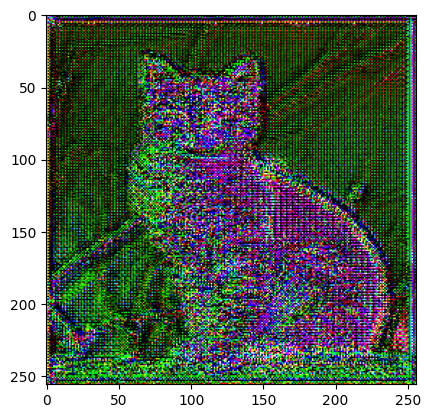

In [52]:
%matplotlib inline

rgb_array = output[0].permute(1, 2, 0).detach().numpy()
rgb_array = rgb_array.clip(0, 1)
plt.imshow(rgb_array)